#Coursework 2 Group 25
Group number: 25

Student names and k-numbers:


1.   Jose Praveen Karuppiah - K2447781
2.   Ash Methven - K1912538
3.   Paul John Shaji - K2374300
4.   Abdi Mumin - K2512635

# Load Modules

In [3]:
#load libraries
#tensorflow and keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras import callbacks
from keras.models import Sequential, load_model
from keras.src.layers import Input, Dense, Dropout, Flatten
from keras.src.layers import Conv2D, MaxPooling2D

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

#support libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, balanced_accuracy_score

# Load and split Data

In [4]:
#load dataset (pet)
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:90%]',
                                                          'train[90%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # returns (image, label)
                                                    with_info=True # to retrieve dataset info and label names
                                                    )

### Visualise some of the data to understand dataset

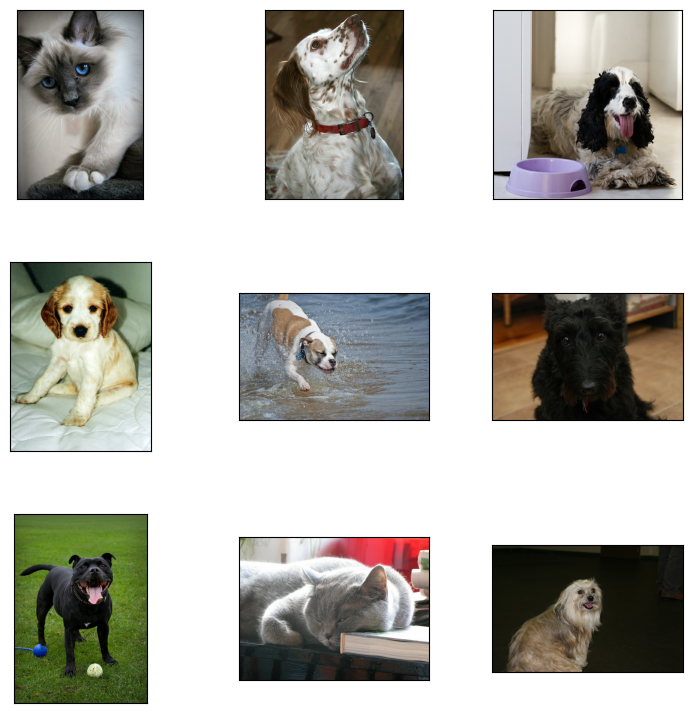

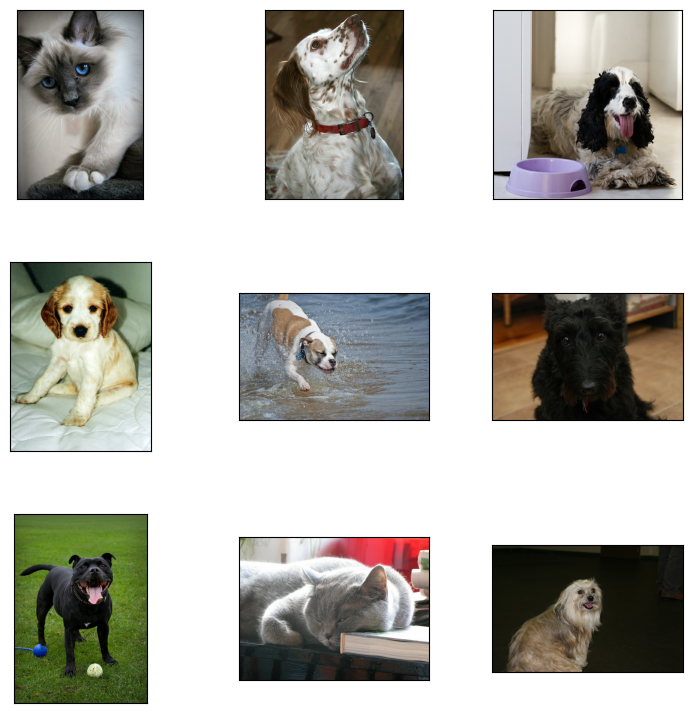

In [5]:
#show some examples from the dataset
tfds.show_examples(train_raw, ds_info, image_key='image')

Image shape:  (333, 500, 3)


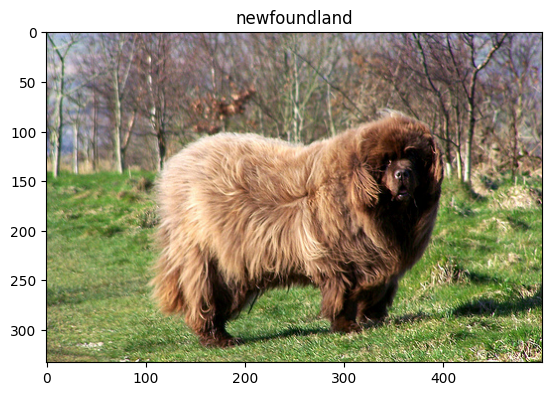

In [6]:
#show detail of a specific image form the dataset
# Function to obtain the name for the label integer
get_label_name = ds_info.features['label'].int2str
get_species_name = ds_info.features['species'].int2str

# Build the custom function to display image and label name
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

view_single_image(train_raw)

# Classification
Models as follows:


1.   Binary model (Dog vs. Cat)
2.   Cat breed classifications
3.   Dog breed classification
4.   Combined classification (all 37 breeds)



# Data processing

### Standardise image size/data normalisation

In [7]:
#data normalisation/image standardisation
IMG_size = 224
BATCH_SIZE = 32

#preprocessing function
#def preprocess(image, label):
#    image = tf.image.resize(image, (IMG_size, IMG_size))  #resize images
#    image = tf.cast(image, tf.float32) / 255.0  #normalize
#    label = tf.cast(label < 12, tf.int32) #cat = 0, dog = 1 (based on label indices)
#    return image, label

# Apply preprocessing to the datasets
#train_ds = train_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#val_ds = val_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#test_ds = test_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_size, IMG_size)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_size, IMG_size)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_size, IMG_size)), y))

### Encoding

In [8]:
#making sure output vector is of length 37 (no. of classes)
num_classes = ds_info.features['label'].num_classes

def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

### Look at data shape

In [9]:
#print one of the split sets to understand problem
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(37,), dtype=tf.float32, name=None))>

# Training
Due to the preprocessing of data involved in some of these models, please either run the combined model first, or follow the instructions at the top of the combined model on order to run it.

#### Cat vs. Dog classification (Binary model)

In [18]:
#ash
def preprocess_binary(image, label):
    image = tf.image.resize(image, (IMG_size, IMG_size))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label < 12, tf.int32) #cat = 0, dog = 1 (based on label indices)
    return image, label

# Apply preprocessing to the datasets
train_ds_binary = train_raw.map(preprocess_binary).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_binary = val_raw.map(preprocess_binary).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_binary = test_raw.map(preprocess_binary).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#cat vs. dog
binary_model = Sequential([
    Input(shape=(IMG_size, IMG_size, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

#implement early stopping to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

#compile model
binary_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

#train model
binary_history = binary_model.fit(train_ds_binary,
                                  epochs = 25,
                                  validation_data = val_ds_binary,
                                  verbose = 1,
                                  callbacks=[earlystopping])

# Evaluate the model
loss, accuracy = binary_model.evaluate(test_ds_binary)
print(f"Test Accuracy: {accuracy}")

Epoch 1/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.6382 - loss: 1.2690 - val_accuracy: 0.6440 - val_loss: 0.6780
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.6597 - loss: 0.6436 - val_accuracy: 0.6440 - val_loss: 0.6946
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6600 - loss: 0.6393 - val_accuracy: 0.6440 - val_loss: 0.6466
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.6599 - loss: 0.6303 - val_accuracy: 0.6467 - val_loss: 0.6915
Epoch 5/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6544 - loss: 0.6295 - val_accuracy: 0.6440 - val_loss: 0.9664
Epoch 6/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6575 - loss: 0.6293 - val_accuracy: 0.6440 - val_loss: 0.7988
Epoch 7/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.6635 - loss: 0.6112 - val_accuracy: 0.6304 - val_loss: 0.6749
Epoch 8/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6922 - loss: 0.5836 - 

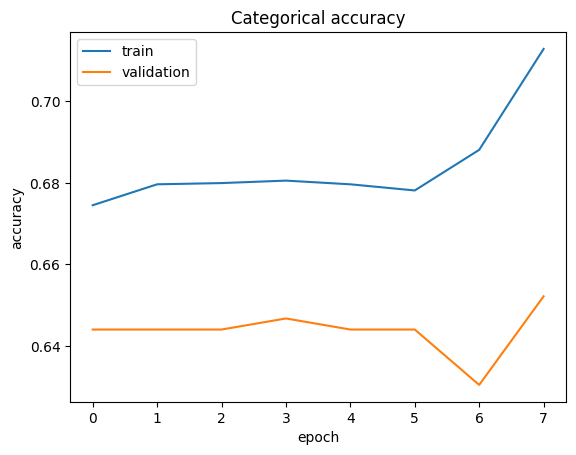

In [19]:
#plot history/accuracy graph
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.plot()
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'test'], loc='upper left')
    plt.show()

plot_hist(binary_history)

#### Cat breed classification


In [20]:
#jose
# Define image size
IMG_size = 128

# Define cat breeds (replace with actual breed names or extract from dataset info)
cat_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
     'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
     'Siamese', 'Sphynx']

# Filter dataset to include only cats
def filter_cats(image, label):
    return tf.less(label, len(cat_breeds))  # Assuming cat breeds are labeled with lower indices

cat_ds = train_raw.filter(filter_cats)
cat_val_ds = val_raw.filter(filter_cats)
cat_test_ds = test_raw.filter(filter_cats)

# Preprocess dataset
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_size, IMG_size))  # Resize images
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, tf.one_hot(label, len(cat_breeds))  # One-hot encode label

cat_ds = cat_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
cat_val_ds = cat_val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
cat_test_ds = cat_test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Define a CNN model for cat breed classification
cat_model = Sequential([
    Input(shape=(IMG_size, IMG_size, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(cat_breeds), activation='softmax')  # Output layer for breeds
])

# Compile model
cat_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
cat_history = cat_model.fit(cat_ds, validation_data=cat_val_ds, epochs=10)

# Evaluate on test set
test_loss, test_acc = cat_model.evaluate(cat_test_ds)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/10
     34/Unknown 11s 212ms/step - accuracy: 0.0736 - loss: 2.8455

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step - accuracy: 0.0741 - loss: 2.8391 - val_accuracy: 0.1374 - val_loss: 2.4615
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.1842 - loss: 2.3847 - val_accuracy: 0.2137 - val_loss: 2.4701
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.3643 - loss: 1.9345 - val_accuracy: 0.2366 - val_loss: 2.3141
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.5807 - loss: 1.3359 - val_accuracy: 0.2519 - val_loss: 2.3711
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.7790 - loss: 0.7626 - val_accuracy: 0.2977 - val_loss: 2.6086
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8832 - loss: 0.4436 - val_accuracy: 0.2824 - val_loss: 2.8317
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9326 - loss: 0.2786 - val_accuracy: 0.3053 - val_loss: 3.5906
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9539 - loss: 0.1949 - val_accuracy: 0.3053 

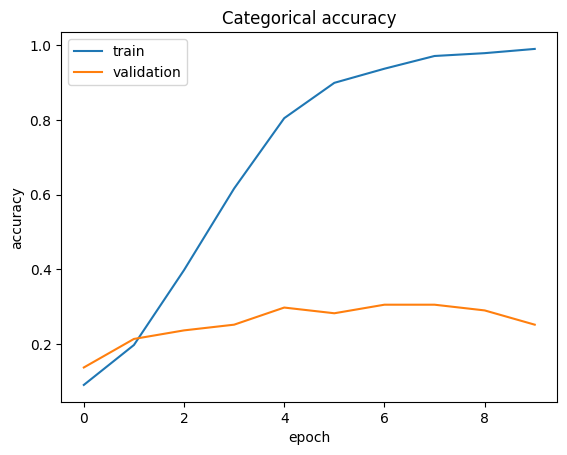

In [21]:
#plot history/accuracy graph
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.plot()
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'test'], loc='upper left')
    plt.show()

plot_hist(cat_history)

#### Dog breed classification

In [22]:
#jose
# Define dog breeds (replace with actual breed names or extract from dataset info)
cat_breeds = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
     'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
     'Siamese', 'Sphynx']

dog_breeds = [
    'American_Bulldog', 'American_Pit_Bull_Terrier', 'Basset_Hound', 'Beagle',
    'Boxer', 'Chihuahua', 'English_Cocker_Spaniel', 'English_Setter', 'German_Shorthaired',
    'Great_Pyrenees', 'Havanese', 'Japanese_Chin', 'Keeshond', 'Leonberger', 'Miniature_Pinscher',
    'Newfoundland', 'Pomeranian', 'Pug', 'Saint_Bernard', 'Samoyed', 'Scottish_Terrier',
    'Shiba_Inu', 'Staffordshire_Bull_Terrier', 'Wheaten_Terrier', 'Yorkshire_Terrier']

# Filter dataset to include only dogs
def filter_dogs(image, label):
    return tf.greater_equal(label, len(cat_breeds))  # Assuming dog breeds are labeled with higher indices

dog_ds = train_raw.filter(filter_dogs)
dog_val_ds = val_raw.filter(filter_dogs)
dog_test_ds = test_raw.filter(filter_dogs)

# Preprocess dataset
def preprocess_dogs(image, label):
    image = tf.image.resize(image, (IMG_size, IMG_size))  # Resize images
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    label = label - len(cat_breeds)  # Adjust label to start from 0 for dogs
    return image, tf.one_hot(label, len(dog_breeds))  # One-hot encode label

dog_ds = dog_ds.map(preprocess_dogs).batch(32).prefetch(tf.data.AUTOTUNE)
dog_val_ds = dog_val_ds.map(preprocess_dogs).batch(32).prefetch(tf.data.AUTOTUNE)
dog_test_ds = dog_test_ds.map(preprocess_dogs).batch(32).prefetch(tf.data.AUTOTUNE)

# Define a CNN model for dog breed classification
dog_model = Sequential([
    Input(shape=(IMG_size, IMG_size, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(dog_breeds), activation='softmax')  # Output layer for dog breeds
])

# Compile model
dog_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
dog_history = dog_model.fit(dog_ds, validation_data=dog_val_ds, epochs=10)

# Evaluate on test set
test_loss, test_acc = dog_model.evaluate(dog_test_ds)
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.0450 - loss: 3.2561 - val_accuracy: 0.0633 - val_loss: 3.2043
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.0740 - loss: 3.1602 - val_accuracy: 0.1519 - val_loss: 2.9177
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.1413 - loss: 2.9044 - val_accuracy: 0.1899 - val_loss: 2.7590
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.2468 - loss: 2.5497 - val_accuracy: 0.1266 - val_loss: 3.0060
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.3846 - loss: 2.1154 - val_accuracy: 0.1857 - val_loss: 3.3013
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5089 - loss: 1.6434 - val_accuracy: 0.1688 - val_loss: 3.9881
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.6279 - loss: 1.2537 - val_accuracy: 0.1435 - val_loss: 4.2551
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.6909 - loss: 1.0359 - val_accuracy:

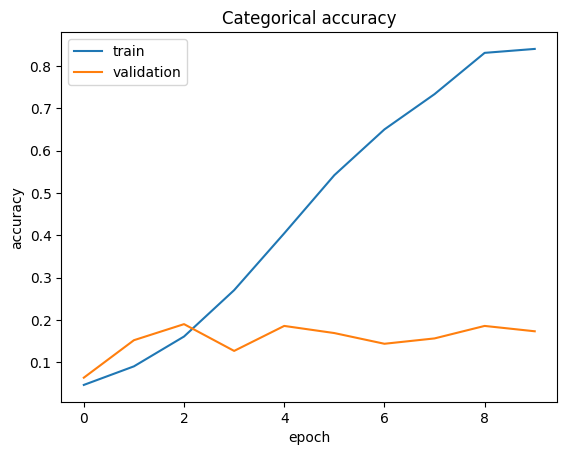

In [23]:
#plot history/accuracy graph
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.plot()
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'test'], loc='upper left')
    plt.show()

plot_hist(dog_history)

#### Combined classification
When running this model, please restart the runtime and run only the code blocks relevant to this model. These are:

1.   Load Modules
2.   Load and split data
3.   Standardise image size/data normalisation
4.   Encoding

Alternatively, you can run this model first before training the others.






In [10]:
#ash
#making sure output vector is of length 37 (no. of classes)
IMG_SIZE = 224

BATCH_SIZE = 32
# Batch the data and use prefetching to optimize loading speed

train_ds = train_ds.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

num_classes = ds_info.features['label'].num_classes

#create a base model using resnet
base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3)
                            )

# Freeze the base_model's weights
base_model.trainable = False

# Pre-process inputs to work with resnet
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs

x = keras.applications.resnet_v2.preprocess_input(x)

x = base_model(x, training=False)

# Rebuild top layers of model we didn't include when setting up base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

combined_model = keras.Model(inputs, outputs)

#summarise new model
combined_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 37)                  │          75,813 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,648,805 (90.21 MB)

 Trainable params: 79,909 (312.14 KB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [11]:
#compile the model
combined_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#implement early stopping to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

In [14]:
#model training
EPOCHS = 25

history = combined_model.fit(train_ds,
                             epochs = EPOCHS,
                             validation_data = val_ds,
                             verbose = 1,
                             callbacks=[earlystopping])

Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - categorical_accuracy: 0.9995 - loss: 0.0221 - val_categorical_accuracy: 0.8807 - val_loss: 0.4300
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - categorical_accuracy: 0.9971 - loss: 0.0244 - val_categorical_accuracy: 0.8608 - val_loss: 0.4947
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - categorical_accuracy: 0.9992 - loss: 0.0149 - val_categorical_accuracy: 0.8523 - val_loss: 0.5427
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - categorical_accuracy: 0.9982 - loss: 0.0132 - val_categorical_accuracy: 0.8580 - val_loss: 0.5151
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - categorical_accuracy: 1.0000 - loss: 0.0096 - val_categorical_accuracy: 0.8693 - val_loss: 0.4761
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - categorical_accuracy: 1.0000 - loss: 0.0079 - val_categorical_accuracy: 0.8722 - val_loss: 0.4813


In [15]:
# Evaluate on test set
combined_test_loss, combined_test_acc = combined_model.evaluate(test_ds)

114/114 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - categorical_accuracy: 0.8646 - loss: 0.5097


Accuracy/history graph

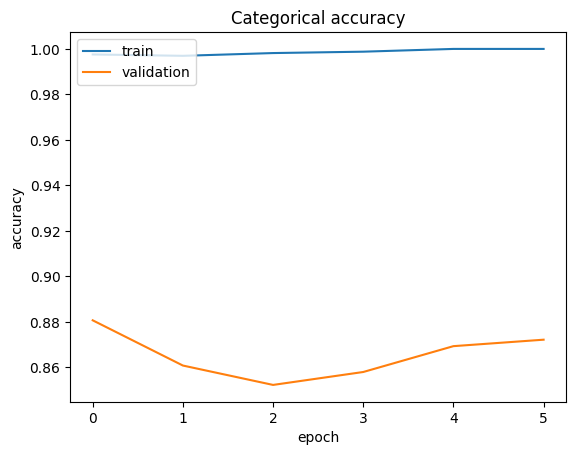

In [16]:
#plot accuracy and history of combined model
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.plot()
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'test'], loc='upper left')
    plt.show()

plot_hist(history)

# Evaluation

#### Binary (Cat vs. Dog) Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━

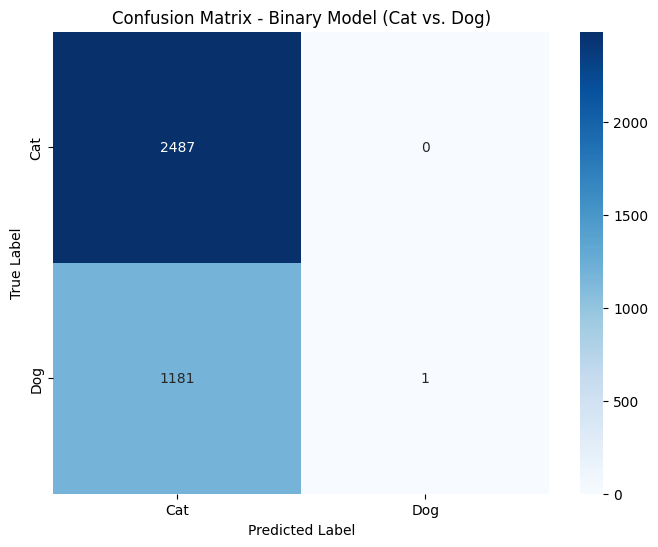

Binary F1 Score: 0.0016906170752324597
Binary Recall: 0.0008460236886632825
Binary Precision: 1.0
Binary Balanced Accuracy: 0.5004230118443317


In [24]:
#create confusion matrix for cat vs. dog model
#get predictions and true labels for the test set
y_true = []
y_pred = []

for images, labels in test_ds_binary:
    predictions = binary_model.predict(images)
    predicted_labels = (predictions >= 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

#generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix - Binary Model (Cat vs. Dog)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#calculate f1 score
binary_f1 = f1_score(y_true, y_pred)
#calculate recall
binary_recall = recall_score(y_true, y_pred)
#calculate precision
binary_precision = precision_score(y_true, y_pred)
#calculate balanced accuracy
binary_baccuracy = balanced_accuracy_score(y_true, y_pred)

#print scores
print(f"Binary F1 Score: {binary_f1}")
print(f"Binary Recall: {binary_recall}")
print(f"Binary Precision: {binary_precision}")
print(f"Binary Balanced Accuracy: {binary_baccuracy}")

#### Cat breed model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

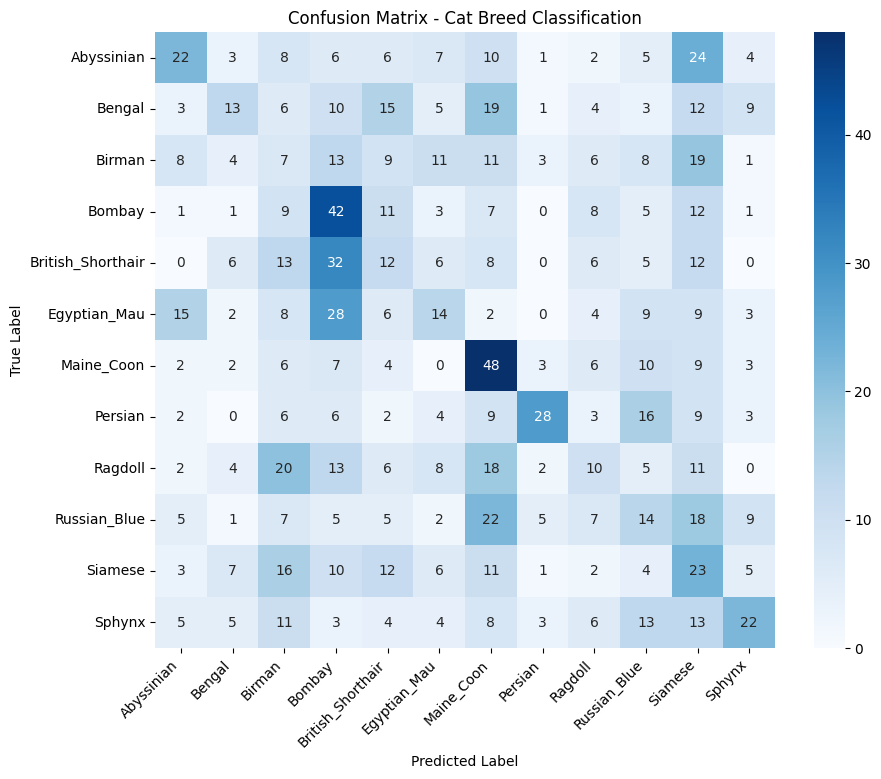

Cat F1 Score: 0.2129433046407607
Cat Recall: 0.2167071532351356
Cat Precision: 0.24163145027801614
Cat Balanced Accuracy: 0.2167071532351356


In [25]:
#create a confusion matrix for cat breed model
#get predictions and true labels for the test set
y_true = []
y_pred = []

for images, labels in cat_test_ds:
    predictions = cat_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  #get the index of the highest probability
    true_labels = np.argmax(labels, axis=1)  #get the index of the true label

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

#generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cat_breeds, yticklabels=cat_breeds)
plt.title('Confusion Matrix - Cat Breed Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')  #rotate x-axis labels for better readability
plt.show()

#calculate f1 score
cat_f1 = f1_score(y_true, y_pred, average = 'weighted')
#calculate recall
cat_recall = recall_score(y_true, y_pred, average = 'macro')
#claculate precision
cat_precision = precision_score(y_true, y_pred, average = 'macro')
#calculate balanced accuracy
cat_baccuracy = balanced_accuracy_score(y_true, y_pred)

#print scores
print(f"Cat F1 Score: {cat_f1}")
print(f"Cat Recall: {cat_recall}")
print(f"Cat Precision: {cat_precision}")
print(f"Cat Balanced Accuracy: {cat_baccuracy}")

#### Dog breed model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

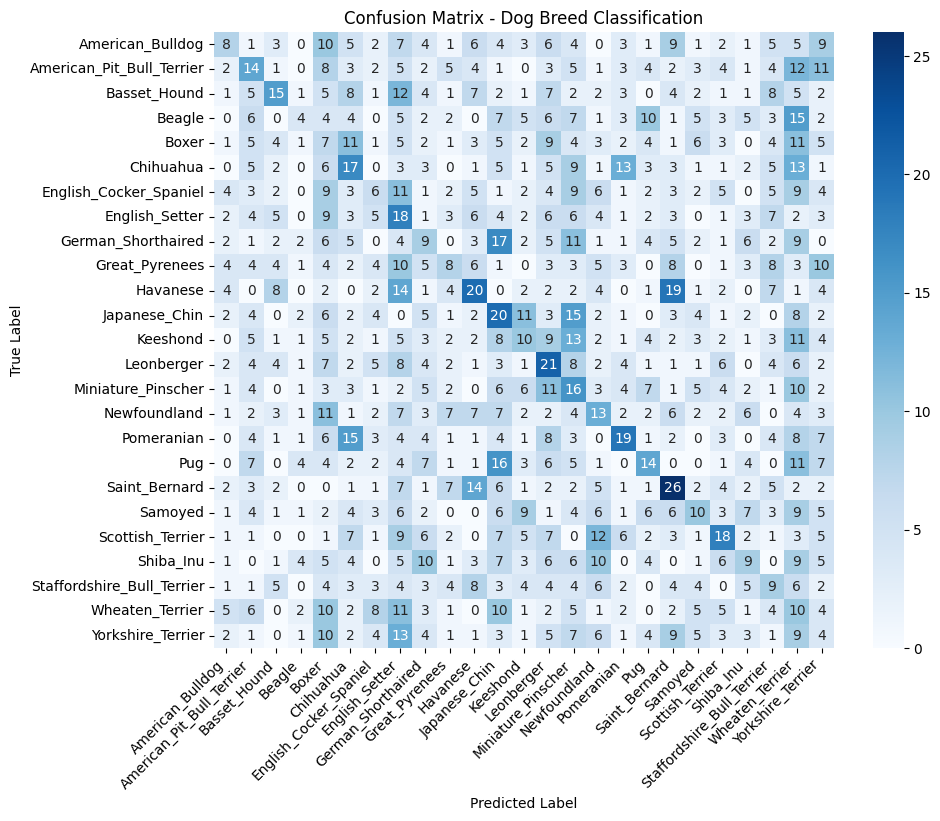

Dog F1 Score: 0.1303315718738568
Dog Recall: 0.13057423674951765
Dog Precision: 0.14018745164624927
Dog Balanced Accuracy: 0.13057423674951765


In [26]:
#create a confusion matrix for dog breed model
#get predictions and true labels for the test set
y_true = []
y_pred = []

for images, labels in dog_test_ds:
    predictions = dog_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)  #get the index of the highest probability
    true_labels = np.argmax(labels, axis=1)  #get the index of the true label

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

#generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dog_breeds, yticklabels=dog_breeds)
plt.title('Confusion Matrix - Dog Breed Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')  #rotate x-axis labels for better readability
plt.show()

#calculate f1 score
dog_f1 = f1_score(y_true, y_pred, average = 'weighted')
#calculate recall
dog_recall = recall_score(y_true, y_pred, average = 'macro')
#calculate precision
dog_precision = precision_score(y_true, y_pred, average = 'macro')
#calculate balanced accuracy
dog_baccuracy = balanced_accuracy_score(y_true, y_pred)

#print scores
print(f"Dog F1 Score: {dog_f1}")
print(f"Dog Recall: {dog_recall}")
print(f"Dog Precision: {dog_precision}")
print(f"Dog Balanced Accuracy: {dog_baccuracy}")

#### Combined model

114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.03      0.03        98
           1       0.03      0.04      0.04       100
           2       0.01      0.01      0.01        99
           3       0.02      0.02      0.02       100
           4       0.00      0.00      0.00        98
           5       0.03      0.04      0.04        99
           6       0.02      0.02      0.02       100
           7       0.03      0.03      0.03        88
           8       0.02      0.02      0.02        98
           9       0.01      0.01      0.01       100
          10       0.04      0.04      0.04        99
          11       0.03      0.03      0.03        95
          12       0.02      0.02      0.02       100
          13       0.01      0.01      0.01        98
          14       0.03      0.04      0.04        97
          15       0.09      0.09      0.09       100
          16  

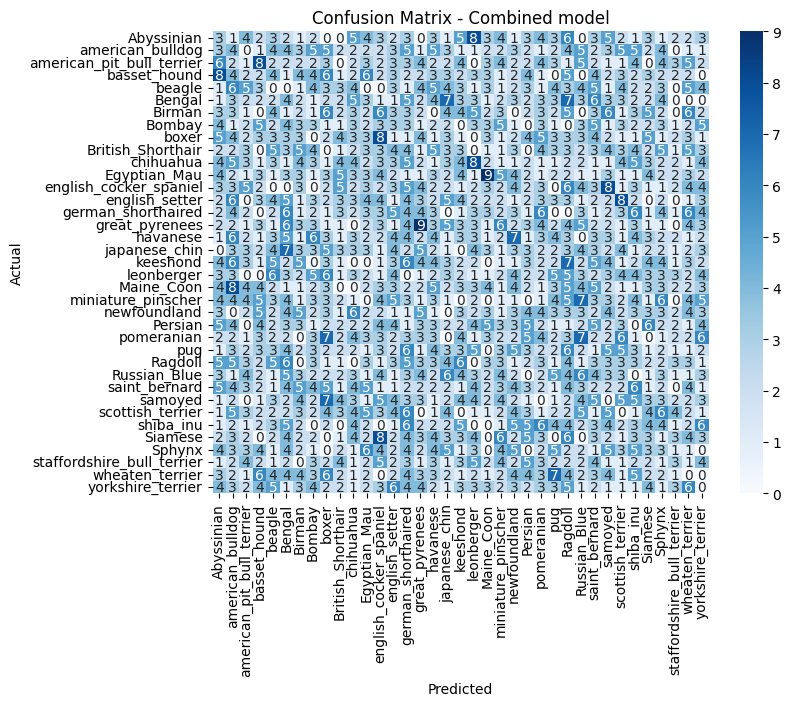

Combined F1 Score: 0.026293165671898416
Combined Recall: 0.02635851460438702
Combined Precision: 0.026534230186599905
Combined Balanced Accuracy: 0.02635851460438702


In [17]:
#create confusion matrix for combined model
#get class names
class_names = ds_info.features['label'].names  # Get class names from ds_info

#get true labels from the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

#get predictions from the model
y_pred = combined_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

#classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

#confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Blues", fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Combined model")
plt.show()

#calculate f1 score
combined_f1 = f1_score(y_true, y_pred, average = 'macro')
#calculate recall
combined_recall = recall_score(y_true, y_pred, average = 'macro')
#calculate precision
combined_precision = precision_score(y_true, y_pred, average = 'macro')
#calculate balanced accuracy
combined_baccuracy = balanced_accuracy_score(y_true, y_pred)

#print scores
print(f"Combined F1 Score: {combined_f1}")
print(f"Combined Recall: {combined_recall}")
print(f"Combined Precision: {combined_precision}")
print(f"Combined Balanced Accuracy: {combined_baccuracy}")

# References
bigmaria (2025). cats vs dogs. [online] Kaggle.com. Available at: https://www.kaggle.com/code/bigmaria/cats-vs-dogs [Accessed 4 Apr. 2025].

kennethleungty (2025). TensorFlow-Transfer-Learning-Image-Classification/notebooks/TensorFlow Tutorial - Image Classification on Oxford-IIIT Pets Dataset.ipynb at main · kennethleungty/TensorFlow-Transfer-Learning-Image-Classification. [online] GitHub. Available at: https://github.com/kennethleungty/TensorFlow-Transfer-Learning-Image-Classification/blob/main/notebooks/TensorFlow%20Tutorial%20-%20Image%20Classification%20on%20Oxford-IIIT%20Pets%20Dataset.ipynb [Accessed 9 Apr. 2025].

KGP Talkie (2023). Deep Learning Tutorial 4 - Cats vs Dogs Classification using CNN & Image Augmentation. [online] YouTube. Available at: https://www.youtube.com/watch?v=7Dbd5DV3Jxk [Accessed 2 Apr. 2025].

Team, K. (n.d.). Keras documentation: Models API. [online] keras.io. Available at: https://keras.io/api/models/.

TensorFlow (2017). Basic classification: Classify images of clothing  |  TensorFlow Core. [online] TensorFlow. Available at: https://www.tensorflow.org/tutorials/keras/classification [Accessed 5 Apr. 2025].

TensorFlow Datasets (2019). oxford_iiit_pet. [online] TensorFlow. Available at: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet [Accessed 9 Apr. 2025].

TensorFlow Datasets (2019). oxford_iiit_pet. [online] TensorFlow. Available at: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet [Accessed 9 Apr. 2025].

Vedaldi, A. (2025). The Oxford-IIIT Pet Dataset. [online] Academic Torrents. Available at: https://academictorrents.com/details/b18bbd9ba03d50b0f7f479acc9f4228a408cecc1 [Accessed 9 Apr. 2025].

Wang, J., Lv, J., Yang, X., Tang, C. and Peng, X. (2020). Multimodal image-to-image translation between domains with high internal variability. Soft Computing, 24(23), pp.18173–18184. doi:https://doi.org/10.1007/s00500-020-05073-6.
